In [24]:
# Import libraries for data processing, modeling, and evaluation
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# CHANGE THE PATH TO YOUR DATA

# Load price data (OHLCV) and sentiment scores from CSV files
price_data = pd.read_csv("/Users/marvinchen/Desktop/ECE 473/forecast-pumpdump/data/crypto_price/DOGE_price_data.csv", parse_dates=["datetime"])

# Load sentiment data with emojis
sentiment_data = pd.read_csv("/Users/marvinchen/Desktop/ECE 473/forecast-pumpdump/data/reddit_posts/post_sentiment/dogecoin_sentiment_wo_emoji.csv", parse_dates=["created_utc"])

In [15]:
# Merge price and sentiment data
merged = pd.merge_asof(
    price_data.sort_values("datetime"),
    sentiment_data.sort_values("created_utc"),
    left_on="datetime",
    right_on="created_utc",
    direction="nearest"
)

# Create target variable
merged["next_close"] = merged["close"].shift(-1)
merged["price_up"] = (merged["next_close"] > merged["close"]).astype(int)
merged.dropna(subset=["price_up"], inplace=True)

In [16]:
# Ensure sentiment columns are numeric
merged["vader_sentiment"] = pd.to_numeric(merged["vader_sentiment"], errors="coerce")
merged["finbert_sliding_sentiment"] = merged["finbert_sliding_sentiment"].map(
    {"neutral": 0, "positive": 1, "negative": -1}
)
merged.dropna(subset=["vader_sentiment", "finbert_sliding_sentiment"], inplace=True)

In [17]:
# Feature engineering
for lag in [1, 2, 3, 4, 5, 6]:
    merged[f"vader_lag{lag}"] = merged["vader_sentiment"].shift(lag)
    merged[f"finbert_lag{lag}"] = merged["finbert_sliding_sentiment"].shift(lag)

merged["returns"] = merged["close"].pct_change()
merged["volatility"] = merged["returns"].rolling(6).std()
merged["volume_change"] = merged["volume"].pct_change()
merged.dropna(inplace=True)

In [25]:
# Define features and target
features = [
    "returns", "volatility", "volume_change",
    "vader_lag1", "vader_lag2", "vader_lag3",
    "finbert_lag1", "finbert_lag2", "finbert_lag3"
]
X = merged[features]
y = merged["price_up"]

print(y.value_counts(normalize=True))

price_up
1    0.530259
0    0.469741
Name: proportion, dtype: float64


In [19]:
# Train-test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [20]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [22]:
# Evaluate model
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")

# Feature importance
coefs = pd.Series(model.coef_[0], index=features)
print("Top Predictive Features:")
print(coefs.abs().sort_values(ascending=False).head(5))

Accuracy: 0.54
AUC-ROC: 0.54
Top Predictive Features:
finbert_lag3    0.510584
finbert_lag2    0.410136
volatility      0.288777
returns         0.233386
vader_lag2      0.128560
dtype: float64


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

              precision    recall  f1-score   support

        Down       0.50      0.34      0.41        32
          Up       0.56      0.71      0.63        38

    accuracy                           0.54        70
   macro avg       0.53      0.53      0.52        70
weighted avg       0.53      0.54      0.53        70



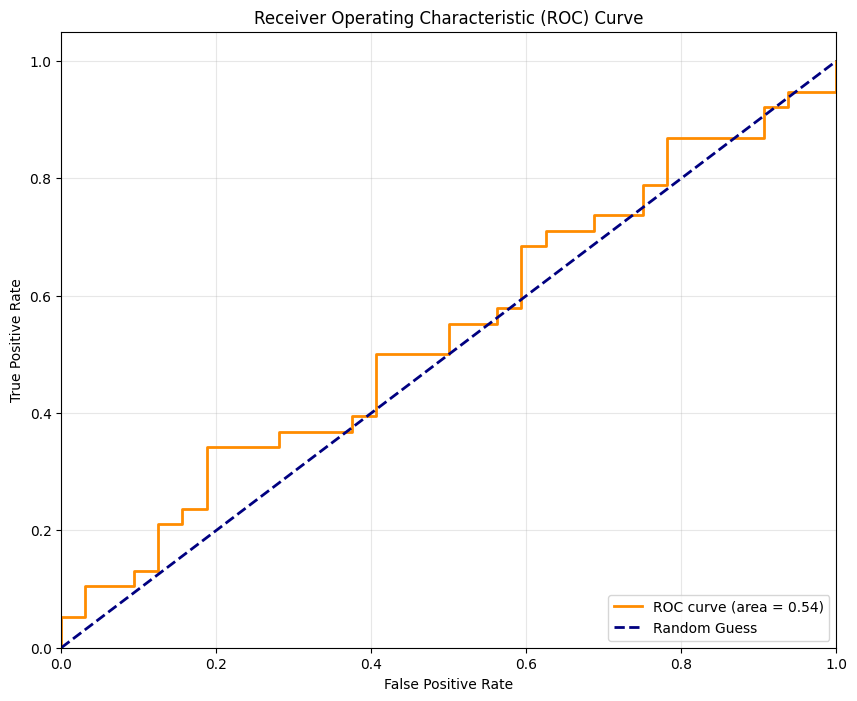

In [28]:
# Add ROC curve analysis
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

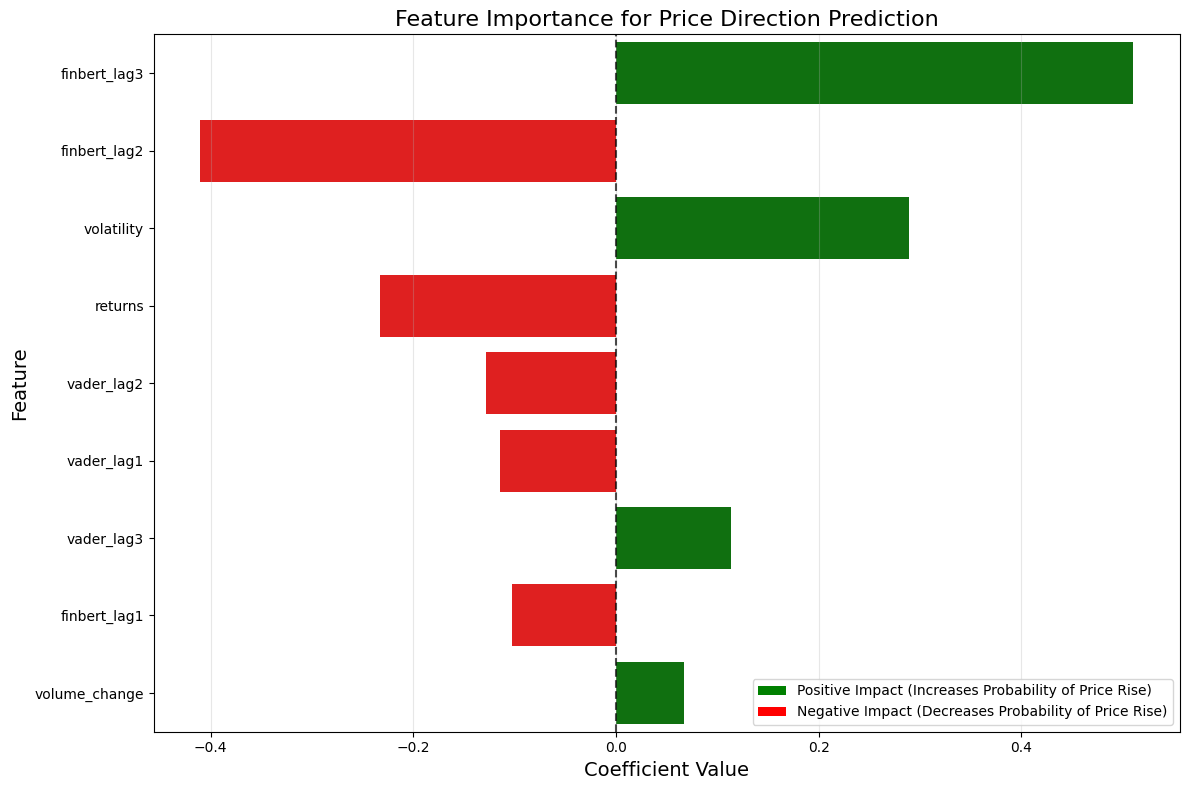

In [37]:
# Add Feature Importance Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from model coefficients
coefs = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0],
    'Absolute': np.abs(model.coef_[0])
})

# Sort by absolute coefficient value
coefs = coefs.sort_values(by='Absolute', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
colors = ['green' if c > 0 else 'red' for c in coefs['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=coefs, hue='Feature', dodge=False, palette=colors, legend=False)

plt.title('Feature Importance for Price Direction Prediction', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.grid(axis='x', alpha=0.3)

# Add a legend explaining the colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Positive Impact (Increases Probability of Price Rise)'),
    Patch(facecolor='red', label='Negative Impact (Decreases Probability of Price Rise)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()